<div style="text-align:left"> LE GOURRIEREC Titouan
<h1><center>MACHINE LEARNING PROJECT : <br/> Machine Learning to detect lung diseases <strong>(WITH RGB to Gray)</strong></center></h1>
<h3><center>IMT Mines Alès</center></h3>

In [1]:
# Data processing libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing libraries
import cv2

# Machine learning algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

# Utility functions and classes from scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

# Handling imbalanced data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# System-related operations
import os

ModuleNotFoundError: No module named 'numpy'

In [4]:
# Dictionary mapping class names to numerical codes
code = {'NORMAL' : 0 , 'PNEUMONIA' : 1}

def getcode(number) :
    '''
    function to return the class of the images from its number

    Parameters :
        number (int): The numerical code for which the corresponding class name is to be retrieved.

    Returns :
        class_name (str) : The class name corresponding to the input numerical code.

    Example :
        code = {'NORMAL': 0, 'PNEUMONIA': 1}
        getcode(0) -> 'NORMAL'
    '''

    for class_name , class_number in code.items() : 
        if number == class_number : 
            return class_name

---
### Images Import 
This code loads images from a specified directory, resizes them to 64x64 pixels, and stores the images and their labels in lists for further processing. <br/>
Then, we create a train set (80%) and a test game (20%).

In [5]:
# Directory containing images
path = '...'

size = 64

# Lists to store resized images and corresponding labels
X_import = []
y_import = []

# Traverse through the directories in the images directory
for folder in os.listdir(path):
    if folder != ".DS_Store":
        files = os.listdir(os.path.join(path, folder)) # Get the list of image files in the current folder
        for file in files:
            if file.endswith('.jpeg'):
                image_path = os.path.join(path, folder, file) # Construct path to the image file
                image = cv2.imread(image_path) # Read the image using OpenCV
                resized_image = cv2.resize(image, (size, size)) # Resize the image to 64 x 64 pixels
                X_import.append(resized_image) # Append the resized image to X_import
                y_import.append(code[folder]) # Append the label of the image to y_import

# Convert lists to numpy arrays for efficient computation
X_import = np.array(X_import)
y_import = np.array(y_import)

Converting to grayscale reduces the dimensionality of the training data by one, making it faster and requiring fewer resources.

In [6]:
# Convert the images to grayscale by taking the mean of color channels
gray_images = np.mean(X_import, axis=-1)
# Flatten the images into one dimension to prepare them for machine learning
gray_images_flatten = gray_images.reshape((-1, 64*64))

X_train, X_test, y_train, y_test = train_test_split(gray_images_flatten, y_import, test_size=0.2, random_state=1234) # random_state=1234 to make the work reproducible

print('Training set size : {}'.format(len(X_train)))
print('Testing set size : {}'.format(len(X_test)))

Training set size : 4684
Testing set size : 1172


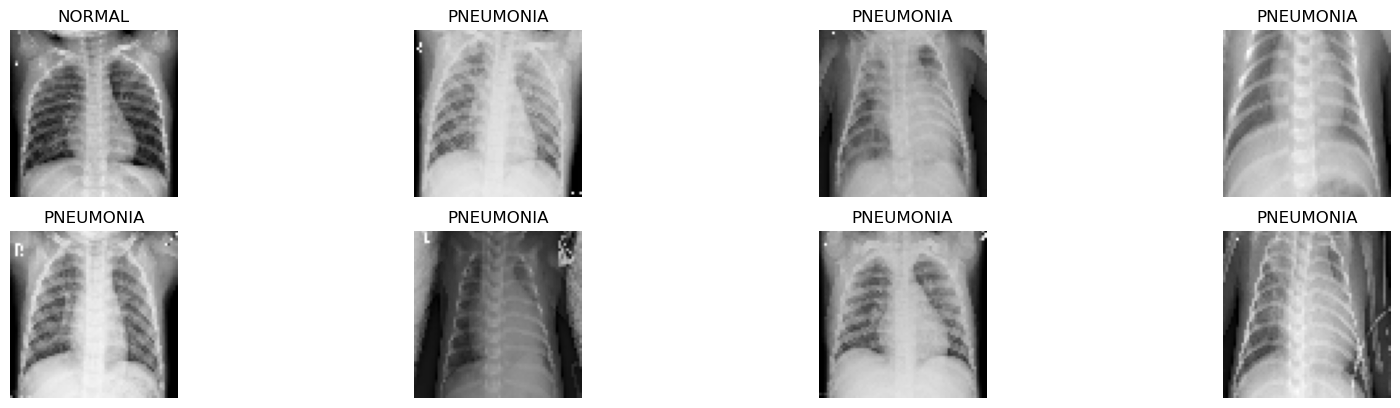

In [7]:
plt.figure(figsize=(20, 10))

# Generate 8 random indices within the range of the training set
for i, j in enumerate(np.random.randint(0, len(X_train), 8)):
    plt.subplot(4, 4, i+1)
    
    plt.imshow(X_train[j].reshape((64,64)), cmap='gray')
    
    plt.axis('off')
    
    plt.title(getcode(y_train[j]))

plt.show()

---
### **Print_metrics** function 
This function prints various evaluation metrics for a classifier : Accuracy, Precision, Recall, F1-score, Confusion matrix. we use it in the rest of the program.

In [8]:
def print_metrics(classifier_name, y_test, y_pred):
    '''
    Prints various evaluation metrics for a classifier.

    Parameters:
        - classifier_name (str): Name of the classifier.
        - y_test (array-like): True labels.
        - y_pred (array-like): Predicted labels.

    Returns:
        None

    Metrics Printed:
        - Accuracy: The proportion of correctly classified instances.
        - Precision: The ratio of correctly predicted positive observations to the total predicted positives.
        - Recall: The ratio of correctly predicted positive observations to the all observations in actual class.
        - F1-score: The weighted average of Precision and Recall.
        - Confusion Matrix: A table used to describe the performance of a classification model.
    '''
    
    print(f'\n{classifier_name} Metrics:')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1-score:', f1_score(y_test, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

---
### Creation, Training and Evaluation of base models
The basic models concern : K Neighbors Classifier, Logistic Regression, Decision Tree Classifier, Support Vector Classifier.  
For each of these basic models, a gridsearch is carried out to determine the best parameters.

#### K Neighbors Classifier :  
The **K-Nearest Neighbors (KNN)** algorithm is a supervised learning method used for classification and regression tasks. It operates by assigning a class to a data point based on the majority classes among its k nearest neighbors, where k is a predefined hyperparameter. In other words, it classifies a new instance based on the most common class among its nearest neighbors in the feature space.  
Hyperparameters modified for grid search :
* `n_neighbors` : the number of nearest data points to consider when making predictions for a new instance.
* `weights` : specifies the weight function used in prediction, where 'uniform' assigns equal weight to all neighbors, and 'distance' assigns weights proportional to the inverse of the distance from the query point, potentially giving closer neighbors more influence on the prediction.
* `metric` : defines the distance metric used to measure the similarity between data points.

In [8]:
# Hyperparameter definition for grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initializing the KNeighbors classifier
knn = KNeighborsClassifier()

# Grid search initialization
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1,scoring='accuracy' ,verbose = 1)

# Executing grid search on training data
grid_search.fit(X_train, y_train)

# Displaying the best found parameters
print("Meilleurs hyperparamètres trouvés : {}".format(grid_search.best_params_))


# Evaluating the model with the best parameters on the test set
best_knn_model = grid_search.best_estimator_
best_knn_pred = best_knn_model.predict(X_test)
print_metrics('Best_KNN', y_test, best_knn_pred)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Meilleurs hyperparamètres trouvés : {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

Best_KNN Metrics:
Accuracy: 0.9283276450511946
Precision: 0.9179431072210066
Recall: 0.9893867924528302
F1-score: 0.9523269012485811
Confusion Matrix:
[[249  75]
 [  9 839]]


#### Logistic Regression :  
**Logistic Regression** is a statistical method used for binary classification tasks, where it models the probability of a binary outcome (such as success/failure or yes/no) based on one or more predictor variables. It works by fitting a logistic function to the observed data, which transforms the output of a linear regression model into a probability value between 0 and 1, allowing it to predict the probability of occurrence of an event.  
Hyperparameters modified for grid search :
* `penalty` : refers to the regularization technique applied to the model to prevent overfitting by penalizing large coefficients. 'l1' penalty adds the absolute values of the coefficients to the cost function,  'l2' penalty adds the squared values of the coefficients.
* `C` : determines the strength of regularization: smaller values of C increase regularization, leading to simpler models, while larger values reduce regularization, allowing the model to fit the data more closely. It acts as a trade-off between fitting the training data well and preventing overfitting.
* `solver` : specifies the algorithm used to optimize the model's parameters. Liblinear is efficient for small and medium-sized datasets, SAGA (Stochastic Average Gradient Ascent) is particularly well-suited for large datasets.

In [9]:
# Hyperparameter definition for grid search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Initializing the Logistic Regression
log_reg = LogisticRegression()

# Grid search initialization
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy',verbose=1)

# Executing grid search on training data
grid_search.fit(X_train, y_train)

# Displaying the best found parameters
print("Meilleurs hyperparamètres trouvés : {}".format(grid_search.best_params_))


# Evaluating the model with the best parameters on the test set
best_log_reg_model = grid_search.best_estimator_
best_log_reg_pred = best_log_reg_model.predict(X_test)
print_metrics('Best_Logistic_Regression', y_test, best_log_reg_pred)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Meilleurs hyperparamètres trouvés : {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}

Best_Logistic_Regression Metrics:
Accuracy: 0.9505119453924915
Precision: 0.9561200923787528
Recall: 0.9764150943396226
F1-score: 0.9661610268378061
Confusion Matrix:
[[286  38]
 [ 20 828]]


/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Decision Tree Classifier :  
A **Decision Tree Classifier** is a machine learning model that makes decisions by splitting the data into branches based on feature values. It starts with a root node and recursively divides the data into subsets based on the feature that provides the best split, aiming to create branches that best separate the classes of the target variable. This process continues until certain stopping criteria are met, resulting in a tree-like structure where each leaf node represents a class label. During prediction, new data is traversed through the tree, following the decisions made at each node until reaching a leaf node, which then predicts the class label.  
Hyperparameters modified for grid search :
* `criterion` : determines the measure used to evaluate the quality of a split at each node during the tree's construction. 'gini' measures impurity or the degree of disorder in the data. It aims to minimize the probability of misclassification by splitting the nodes in a way that reduces impurity, 'entropy' measures the level of randomness or uncertainty in the data. It splits the nodes to maximize information gain, aiming to decrease entropy and increase homogeneity in each node.
* `max_depth` : controls the maximum depth of the tree. It limits the number of levels or nodes from the root to the farthest leaf.
* `min_samples_split` : sets the minimum number of samples required to split an internal node.
* `min_samples_leaf` :  sets the minimum number of samples required to be at a leaf node.

In [10]:
# Hyperparameter definition for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initializing the Decision Tree Classifier
decision_tree = DecisionTreeClassifier()

# Grid search initialization
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, n_jobs=-1, verbose = 1)

# Executing grid search on training data
grid_search.fit(X_train, y_train)

# Displaying the best found parameters
print("Meilleurs hyperparamètres trouvés : {}".format(grid_search.best_params_))


# Evaluating the model with the best parameters on the test set
best_decision_tree_model = grid_search.best_estimator_
best_decision_tree_pred = best_decision_tree_model.predict(X_test)
print_metrics('Best_Decision_Tree', y_test, best_decision_tree_pred)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Meilleurs hyperparamètres trouvés : {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

Best_Decision_Tree Metrics:
Accuracy: 0.8549488054607508
Precision: 0.886986301369863
Recall: 0.9162735849056604
F1-score: 0.9013921113689095
Confusion Matrix:
[[225  99]
 [ 71 777]]


#### Support Vector Classifier :  
**Support Vector Classifier (SVC)** is a classification algorithm that finds the best hyperplane to separate different classes by maximizing the margin between them, making use of support vectors as the closest data points to the hyperplane.  
Hyperparameters modified for grid search :
* `C` : controls the regularization strength.
* `kernel` : specifies the type of kernel function used to transform the input features into a higher-dimensional space where the data may be more separable. Linear creates a linear decision boundary in the original feature space, Poly uses polynomial functions to map the data into a higher-dimensional space, allowing for more complex decision boundaries, RBF transforms the data into an infinite-dimensional space using Gaussian radial basis functions, effectively capturing non-linear relationships in the data.
* `gamma` : determines how far the influence of a single training example reaches, affecting the flexibility of the decision boundary.
* `degree` :  specifies the degree of the polynomial used to transform the data into a higher-dimensional space (with poly kernel).

In [11]:
# Hyperparameter definition for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# Initializing the SVC
svc = SVC()

# Grid search initialization
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Executing grid search on training data
grid_search.fit(X_train, y_train)

# Displaying the best found parameters
print("Meilleurs hyperparamètres trouvés : {}".format(grid_search.best_params_))

# Evaluating the model with the best parameters on the test set
best_svc_model = grid_search.best_estimator_
best_svc_pred = best_svc_model.predict(X_test)
print_metrics('Best_SVC', y_test, best_svc_pred)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs hyperparamètres trouvés : {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Best_SVC Metrics:
Accuracy: 0.9505119453924915
Precision: 0.9603729603729604
Recall: 0.9716981132075472
F1-score: 0.9660023446658852
Confusion Matrix:
[[290  34]
 [ 24 824]]


---
### Creation, Training and Evaluation of ensemble models
The ensemble models concern : Random Forest Classifier, Gradient Boosting Classifier, VotingClassifier.  
We carry out a grid search for the random forest classifier but for reasons of time and resources, we cannot do it for the gradient boosting classifier and the voting classifier.

#### Random Forest Classifier :  
The Random Forest Classifier is an ensemble learning method that constructs a multitude of decision trees during training. Each tree is trained on a random subset of the training data and a random subset of features. During prediction, each tree independently outputs a class prediction, and the final prediction is determined by aggregating the votes from all the trees. This ensemble approach helps improve accuracy and generalization while also providing insights into feature importance. Additionally, the randomness introduced during tree construction helps mitigate overfitting, making Random Forest a powerful and widely used algorithm in classification tasks.  
Hyperparameters modified for grid search :
* `n_estimators` : specifies the number of decision trees to be created in the forest.
* `max_depth` : same as decision tree.
* `min_samples_split` : same as decision tree.
* `min_samples_leaf` :  same as decision tree.

In [12]:
# Hyperparameter definition for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initializing the Random Forest Classifier
random_forest = RandomForestClassifier()

# Grid search initialization
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Executing grid search on training data
grid_search.fit(X_train, y_train)

# Displaying the best found parameters
print("Meilleurs hyperparamètres trouvés : {}".format(grid_search.best_params_))

# Evaluating the model with the best parameters on the test set
best_random_forest_model = grid_search.best_estimator_
best_random_forest_pred = best_random_forest_model.predict(X_test)
print_metrics('Best_Random_Forest', y_test, best_random_forest_pred)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs hyperparamètres trouvés : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Best_Random_Forest Metrics:
Accuracy: 0.9428327645051194
Precision: 0.9452679589509693
Recall: 0.9775943396226415
F1-score: 0.9611594202898551
Confusion Matrix:
[[276  48]
 [ 19 829]]


#### Gradient Boosting Classifier :  
The Gradient Boosting Classifier is an ensemble learning technique that combines multiple weak predictive models, such as decision trees, sequentially to create a strong predictive model. It focuses on correcting the errors of the previous models in each iteration, resulting in improved overall performance.

In [13]:
# Initialize the Gradient Boosting Classifier with the specified hyperparameters
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
gb_clf.fit(X_train, y_train)
gb_clf_pred = gb_clf.predict(X_test)

# Display performance metrics
print_metrics('Best_Gradient_Bosting', y_test, gb_clf_pred)


Best_Gradient_Bosting Metrics:
Accuracy: 0.9453924914675768
Precision: 0.9424379232505643
Recall: 0.9846698113207547
F1-score: 0.9630911188004614
Confusion Matrix:
[[273  51]
 [ 13 835]]


#### Voting Classifier
The Voting Classifier is an ensemble learning method that combines the predictions from multiple individual classifiers and predicts the class label by majority vote (for classification tasks) or by averaging (for regression tasks). It aggregates the predictions from different models, which may have been trained on different algorithms or subsets of data, to make a final prediction. This approach often leads to better generalization and robustness compared to using a single classifier.  
`voting = 'hard' to vote for the most frequent class, 'soft' to vote based on probabilities`

#### Hard Voting :

In [14]:
from sklearn.ensemble import VotingClassifier

# Initialize individual classifiers for the Voting Classifier
knn_voting = KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')
log_reg_voting = LogisticRegression(C = 10, penalty='l2', solver= 'saga')
decision_tree_voting = DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_leaf=1,min_samples_split=10)
random_forest_voting = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300)
SVC_voting = SVC(C=100, degree=2, gamma='scale', kernel='rbf')

# Create the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('knn', knn_voting),
    ('log_reg', log_reg_voting),
    ('decision_tree', decision_tree_voting),
    ('random_forest', random_forest_voting),
    ('svc', SVC_voting)
], voting='hard')  # 'hard' for voting for the most frequent class, 'soft' for voting based on probabilities

# Train the Voting Classifier on the training data
voting_clf.fit(X_train, y_train)

# Make predictions on the test set
voting_clf_pred = voting_clf.predict(X_test)

# Display performance metrics
print_metrics('VotingClassifier', y_test, voting_clf_pred)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



VotingClassifier Metrics:
Accuracy: 0.9564846416382252
Precision: 0.9554285714285714
Recall: 0.9858490566037735
F1-score: 0.9704004643064422
Confusion Matrix:
[[285  39]
 [ 12 836]]


#### Soft Voting :

In [15]:
from sklearn.ensemble import VotingClassifier

# Initialize individual classifiers for the Voting Classifier
SVC_voting = SVC(C=100, degree=2, gamma='scale', kernel='rbf', probability=True)
knn_voting = KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')
log_reg_voting = LogisticRegression(C = 10, penalty='l2', solver= 'saga')
decision_tree_voting = DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_leaf=1,min_samples_split=10)
random_forest_voting = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300)

# Create the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('knn', knn_voting),
    ('log_reg', log_reg_voting),
    ('decision_tree', decision_tree_voting),
    ('random_forest', random_forest_voting),
    ('svc', SVC_voting)
], voting='soft')  # 'hard' for voting for the most frequent class, 'soft' for voting based on probabilities

# Train the Voting Classifier on the training data
voting_clf.fit(X_train, y_train)

# Make predictions on the test set
voting_clf_pred = voting_clf.predict(X_test)

# Display performance metrics
print_metrics('VotingClassifier', y_test, voting_clf_pred)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



VotingClassifier Metrics:
Accuracy: 0.9564846416382252
Precision: 0.9543899657924744
Recall: 0.9870283018867925
F1-score: 0.9704347826086958
Confusion Matrix:
[[284  40]
 [ 11 837]]


---
### The problem of imbalanced classes
The problem of imbalanced classes occurs when there is a significant disparity in the number of observations between different classes of a target variable in a dataset. This means that one class is much more represented than the others.

This imbalance can pose challenges during the training of machine learning models, as algorithms tend to favor the majority classes at the expense of the minority ones. This can lead to biased models that primarily predict the majority class and overlook the minority classes.

Consequences of class imbalance include poor model performance on minority classes, low sensitivity (true positive rate), and high specificity (true negative rate).

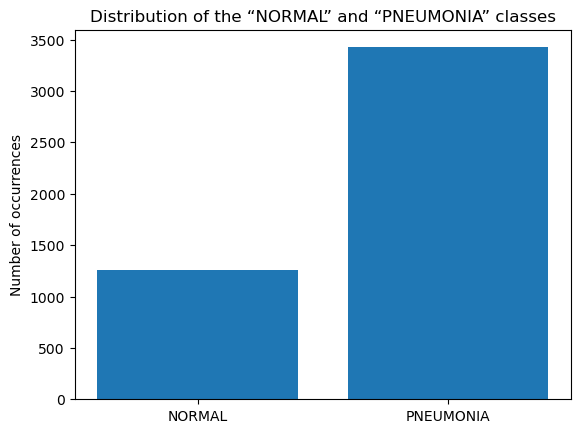

In [16]:
def hist(y_train): # Count the number of zeros and ones
    counts = np.bincount(y_train)

    # Create a bar plot
    plt.bar([0, 1], counts, tick_label=['NORMAL', 'PNEUMONIA'])

    plt.ylabel('Number of occurrences')
    plt.title('Distribution of the “NORMAL” and “PNEUMONIA” classes')
    
    plt.show()

hist(y_train)

---
Model used :

In [17]:
# Créer les classifieurs individuels
knn_voting = KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')
log_reg_voting = LogisticRegression(C=10, penalty='l2', solver='saga')
decision_tree_voting = DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_leaf=1, min_samples_split=10)
random_forest_voting = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300)
SVC_voting = SVC(C=100, degree=2, gamma='scale', kernel='rbf', probability=True)

# Créer le Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('knn', knn_voting),
    ('log_reg', log_reg_voting),
    ('decision_tree', decision_tree_voting),
    ('random_forest', random_forest_voting),
    ('svc', SVC_voting)
], voting='soft')

Split the training data into training and validation sets :

In [9]:
new_X_train, X_val, new_y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1234)

### Oversampling technique
Oversampling is a technique used to address class imbalance by increasing the representation of the minority class through duplicating or generating new examples, thus balancing the class distribution in the dataset.

#### RandomOverSampler
The RandomOverSampler in imbalanced-learn (imblearn) is a technique used to balance class distribution by randomly duplicating examples from the minority class(es) until the class distribution is approximately equal to that of the majority class.

Search for the best generation rate of new examples on the validation set :

In [19]:
# Define different values for the oversampling parameter
sampling_strategies = [0.5, 0.75, 1]

# Initialize variables to store results
best_accuracy = 0
best_sampling_strategy = None
best_y_pred = None

# Loop over different values of the oversampling parameter
for strategy in sampling_strategies:
    # Apply oversampling on the training data
    ros = RandomOverSampler(sampling_strategy=strategy, random_state=1234)
    X_train_resampled, y_train_resampled = ros.fit_resample(new_X_train, new_y_train)
    
    # Train the Voting Classifier on the oversampled training data
    voting_clf.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test dataset
    y_pred = voting_clf.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    # Check if this strategy gives a better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sampling_strategy = strategy
        best_y_pred = y_pred

# Display the best found parameter
print("best sampling strategy :", best_sampling_strategy)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


best sampling strategy : 0.5


Evaluate on the test set :

In [20]:
# Apply oversampling on the training data
ros = RandomOverSampler(sampling_strategy=best_sampling_strategy, random_state=1234)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the Voting Classifier on the oversampled training data
voting_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test dataset
y_pred = voting_clf.predict(X_test)

# Display performance metrics
print_metrics('voting_clf with RandomOverSampler', y_test, y_pred)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



voting_clf with RandomOverSampler Metrics:
Accuracy: 0.9547781569965871
Precision: 0.9584775086505191
Recall: 0.9799528301886793
F1-score: 0.9690962099125365
Confusion Matrix:
[[288  36]
 [ 17 831]]


#### SMOTE (Synthetic Minority Over-sampling Technique) : 
SMOTE is an oversampling technique that aims to balance datasets by increasing the representation of the minority class.
It works by generating new synthetic examples for the minority class by extrapolating points from the nearest neighbors in the attribute space.

<center>

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*CeOd_Wbn7O6kpjSTKTIUog.png" style="width:600px;">

</center>

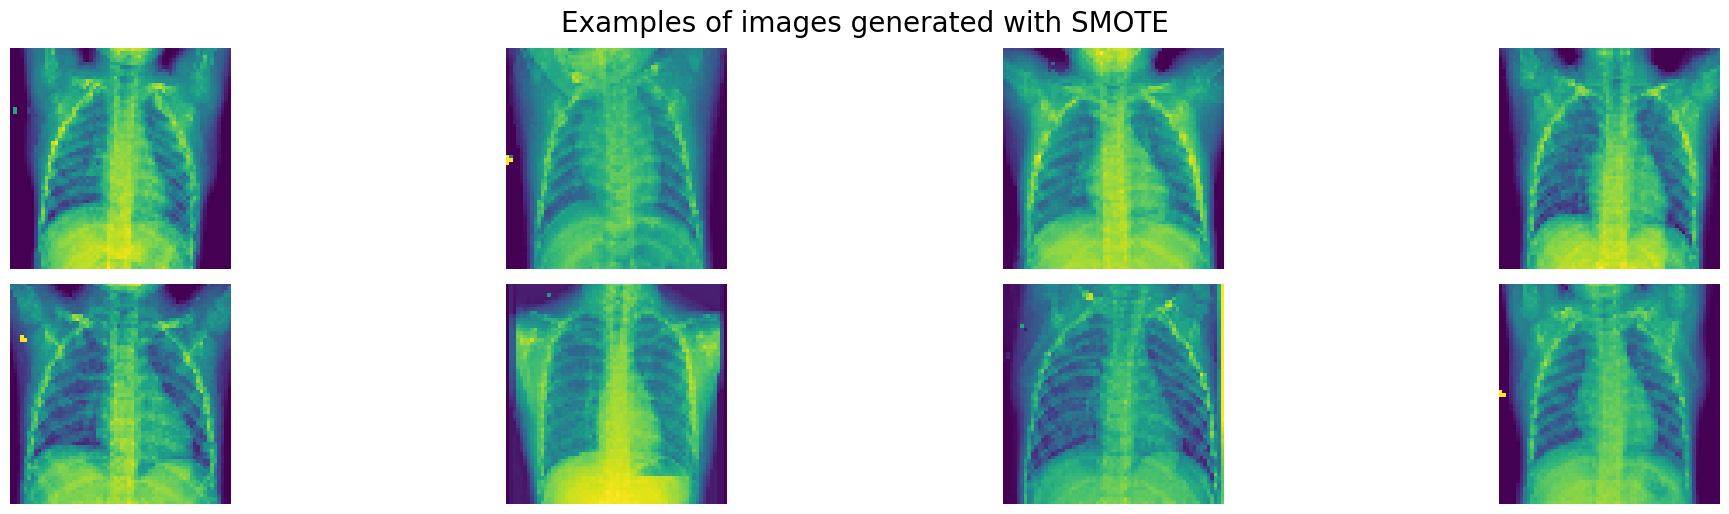

In [21]:
smote = SMOTE(random_state=1234)
X_example, y_example= smote.fit_resample(X_train, y_train)

plt.figure(figsize=(20, 10))
plt.suptitle("Examples of images generated with SMOTE", fontsize=20)  # Titre global

# Generate 8 random indices within the range of the training set
for i, j in enumerate(np.random.randint(len(X_train), len(X_example), 8)):
    plt.subplot(4, 4, i+1)
    
    img = X_example[j].reshape((64,64,1))
    plt.imshow(img)
    
    plt.axis('off')

plt.tight_layout()
plt.show()

Search for the best generation rate of new examples on the validation set :

In [22]:
# Define different values for the SMOTE parameter
sampling_strategies = [0.5, 0.75, 1]

# Initialize variables to store results
best_accuracy = 0
best_sampling_strategy = None
best_y_pred = None

# Loop over different values of the oversampling parameter
for strategy in sampling_strategies:
    # Apply SMOTE on the training data
    smote = SMOTE(sampling_strategy=strategy, random_state=1234)
    X_train_resampled, y_train_resampled = smote.fit_resample(new_X_train, new_y_train)
    
    # Train the Voting Classifier on the oversampled training data
    voting_clf.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test dataset
    y_pred = voting_clf.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    # Check if this strategy gives a better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sampling_strategy = strategy
        best_y_pred = y_pred

# Display the best found parameter
print("best sampling strategy :", best_sampling_strategy)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


best sampling strategy : 1


Evaluate on the test set :

In [23]:
# Apply oversampling on the training data
smote = SMOTE(sampling_strategy=best_sampling_strategy, random_state=1234)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the Voting Classifier on the oversampled training data
voting_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test dataset
y_pred = voting_clf.predict(X_test)

# Display performance metrics
print_metrics('voting_clf with SMOTE', y_test, y_pred)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



voting_clf with SMOTE Metrics:
Accuracy: 0.9539249146757679
Precision: 0.9584295612009238
Recall: 0.9787735849056604
F1-score: 0.9684947491248541
Confusion Matrix:
[[288  36]
 [ 18 830]]


### Undersampling technique
Undersampling is a technique used to address class imbalance by reducing the representation of the majority class. This is typically achieved by randomly removing examples from the majority class, effectively downsampling it. By doing so, the class distribution becomes more balanced, allowing the model to give equal consideration to both classes during training.

#### RandomUnderSampler
The RandomUnderSampler in imbalanced-learn (imblearn) is a technique used to balance class distribution by randomly removing examples from the majority class(es) until the class distribution is approximately equal to that of the minority class.

Search for the best generation rate of new examples on the validation set :

In [24]:
# Define different values for the RandomUnderSampler parameter
sampling_strategies = [0.5, 0.75, 1]

# Initialize variables to store results
best_accuracy = 0
best_sampling_strategy = None
best_y_pred = None

# Boucle sur les différentes valeurs du paramètre de sous-échantillonnage
for strategy in sampling_strategies:
    # Appliquer l'undersampling sur les données d'entraînement
    rus = RandomUnderSampler(sampling_strategy=strategy, random_state=1234)
    X_train_resampled, y_train_resampled = rus.fit_resample(new_X_train, new_y_train)  # Utiliser fit_resample() pour l'undersampling
    
    # Entraîner le Voting Classifier sur les données d'entraînement sous-échantillonnées
    voting_clf.fit(X_train_resampled, y_train_resampled)
    
    # Faire des prédictions sur le jeu de données de test
    y_pred = voting_clf.predict(X_val)
    
    # Calculer l'accuracy
    accuracy = accuracy_score(y_val, y_pred)

    # Vérifier si cette stratégie donne une meilleure accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sampling_strategy = strategy
        best_y_pred = y_pred

# Afficher le meilleur paramètre trouvé
print("best sampling strategy :", best_sampling_strategy)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


best sampling strategy : 0.75


In [25]:
# Appliquer l'undersampling sur les données d'entraînement
rus = RandomUnderSampler(sampling_strategy=best_sampling_strategy, random_state=1234)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)  # Utiliser fit_resample() pour l'undersampling

# Train the Voting Classifier on the oversampled training data
voting_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test dataset
y_pred = voting_clf.predict(X_test)

# Display performance metrics
print_metrics('voting_clf with RandomUnderSampler', y_test, y_pred)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



voting_clf with RandomUnderSampler Metrics:
Accuracy: 0.9564846416382252
Precision: 0.9671746776084408
Recall: 0.972877358490566
F1-score: 0.9700176366843034
Confusion Matrix:
[[296  28]
 [ 23 825]]


### Weight modification technique
This method assigns different weights to classes based on their frequencies to handle class imbalance, enabling individual classifiers to focus more on minority classes during training. The Voting Classifier aggregates predictions from these classifiers, providing a balanced and improved performance across classes in the classification task.

In [26]:
# Compute class weights for training data
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create individual classifiers with balanced class weights
knn_voting = KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')
log_reg_voting = LogisticRegression(C=10, penalty='l2', solver='saga', class_weight=dict(enumerate(class_weights)))
decision_tree_voting = DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_leaf=1, min_samples_split=10, class_weight=dict(enumerate(class_weights)))
random_forest_voting = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300, class_weight=dict(enumerate(class_weights)))
SVC_voting = SVC(C=100, degree=2, gamma='scale', kernel='rbf', probability=True, class_weight=dict(enumerate(class_weights)))

# Create the Voting Classifier
voting_clf_weight = VotingClassifier(estimators=[
    ('knn', knn_voting),
    ('log_reg', log_reg_voting),
    ('decision_tree', decision_tree_voting),
    ('random_forest', random_forest_voting),
    ('svc', SVC_voting)
], voting='soft')

# Train the Voting Classifier
voting_clf_weight.fit(X_train, y_train)

# Make predictions on the test set
voting_clf_weight_pred = voting_clf_weight.predict(X_test)

# Display performance metrics
print_metrics('VotingClassifier', y_test, voting_clf_weight_pred)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



VotingClassifier Metrics:
Accuracy: 0.9607508532423208
Precision: 0.960919540229885
Recall: 0.9858490566037735
F1-score: 0.9732246798603026
Confusion Matrix:
[[290  34]
 [ 12 836]]


---
## Final model
Une fois le meilleur modèle sélectionné, la validation croisée est essentielle pour évaluer sa capacité à généraliser correctement et éviter le surajustement. En utilisant l'ensemble complet de données, cette approche maximise l'utilisation des données disponibles et fournit une estimation précise de la performance du modèle dans diverses conditions. Cela renforce sa fiabilité et sa capacité à fournir des prédictions précises dans des situations réelles.

In [34]:
X = gray_images_flatten
y = y_import

# Compute class weights for training data
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create individual classifiers with balanced class weights
knn_voting = KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')
log_reg_voting = LogisticRegression(C=10, penalty='l2', solver='saga', class_weight=dict(enumerate(class_weights)))
decision_tree_voting = DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_leaf=1, min_samples_split=10, class_weight=dict(enumerate(class_weights)))
random_forest_voting = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300, class_weight=dict(enumerate(class_weights)))
SVC_voting = SVC(C=100, degree=2, gamma='scale', kernel='rbf', probability=True, class_weight=dict(enumerate(class_weights)))

# Create the Voting Classifier
voting_clf_weight = VotingClassifier(estimators=[
    ('knn', knn_voting),
    ('log_reg', log_reg_voting),
    ('decision_tree', decision_tree_voting),
    ('random_forest', random_forest_voting),
    ('svc', SVC_voting)
], voting='soft')


# Perform cross-validation predictions
cv_predictions = cross_val_predict(voting_clf_weight, X, y, cv=10)

# Calculate metrics
accuracy = accuracy_score(y, cv_predictions)
precision = precision_score(y, cv_predictions, average='weighted')
recall = recall_score(y, cv_predictions, average='weighted')
f1 = f1_score(y, cv_predictions, average='weighted')
conf_matrix = confusion_matrix(y, cv_predictions)

# Display performance metrics
print_metrics('Final Model K-Fold Cross Validation', y, cv_predictions)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


Final Model K-Fold Cross Validation Metrics:
Accuracy: 0.950136612021858
Precision: 0.9568510442965343
Recall: 0.9756611280131056
F1-score: 0.9661645422943221
Confusion Matrix:
[[1395  188]
 [ 104 4169]]


In [39]:
from sklearn.model_selection import learning_curve

# Define the sizes of training sets to be used in the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=voting_clf_weight, 
    X=X, 
    y=y, 
    train_sizes=np.linspace(0.1, 1.0, 15), 
    cv=3  # Use 3-fold cross-validation
)

# Calculate the mean scores and standard deviations for training and test sets
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/titouanlegourrierec/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

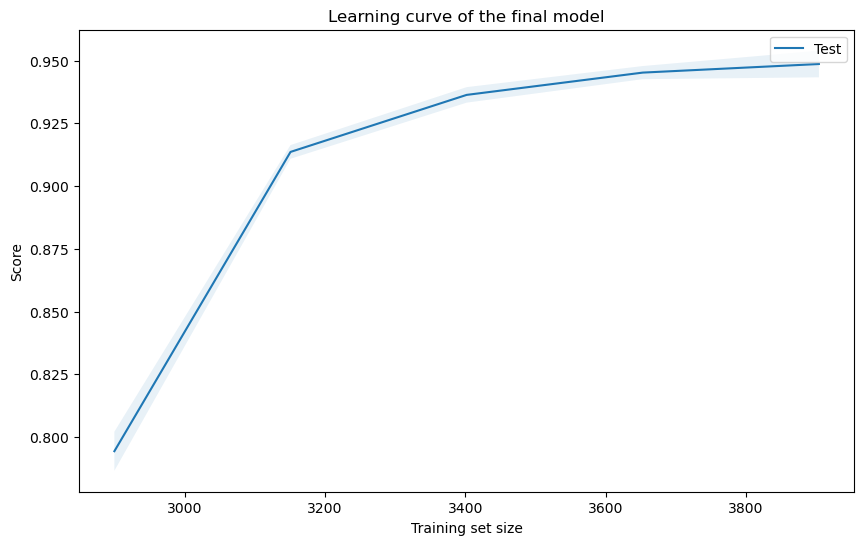

In [40]:
# display the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
plt.title('Learning curve of the final model')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend()
plt.show()

<h1><center>END<br/></h1>
<div style="text-align:left"> LE GOURRIEREC Titouan